### Data from https://www.kaggle.com/c/digit-recognizer

Go to [Data Preparation](#data)

Go to [CNN](#CNN)

Go to [Evaluation](#evaluation)

# Digit Recognizer using TensorFlow Keras

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12394757828033642037
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 8366109437709238564
physical_device_desc: "device: XLA_CPU device"
]


### No GPU on this laptop :(

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

sns.set(style='white', context='notebook', palette='deep')

<a id='data' />

# Data preparation

In [3]:
# Load the data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

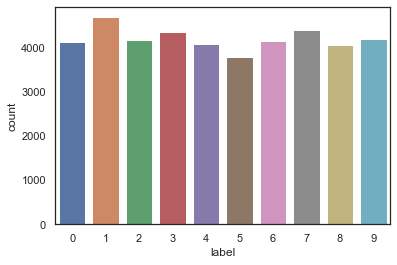

In [11]:
trainY = train["label"]
trainX = train.drop(labels = ["label"],axis = 1) 
del train 

g = sns.countplot(trainY)

trainY.value_counts()

We have similar counts for the 10 digits.

In [36]:
trainX

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


- 28X28 pixels

## Missing values

In [13]:
# Check the data
trainX.isnull().sum().sum()

0

In [14]:
test.isnull().sum().sum()

0

No missing values in the train and test dataset.

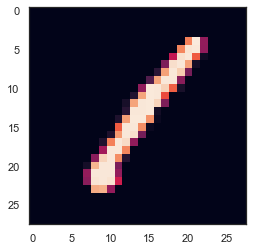

In [29]:
# Some examples
g = plt.imshow(trainX.values.reshape(-1,28,28,1)[0][:,:,0])

## Grayscale Normalization

In [34]:
# Normalize the data
trainX = trainX / trainX.max().max()
test = test / trainX.max().max()

## Reshape

In [39]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , channel = 1)
trainX = trainX.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

- grayscaled images, hence one channel

## Label encoding

In [40]:
# labels to one hot vectors
trainY = to_categorical(trainY, num_classes = 10)

In [41]:
trainY

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [42]:
trainY.shape

(42000, 10)

## Split training and valdiation set 

In [45]:
# Split the train and the validation set for the fitting
trainX, valX, trainY, valY = train_test_split(trainX, trainY, test_size = 0.1)

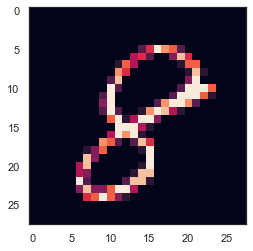

In [54]:
# Some examples
g = plt.imshow(trainX[0][:,:,0])

<a id='CNN' />

# CNN
## Modeling

In [55]:
#[[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1))) #filters = num of filters, kernel_size = filter size
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

#fully connected
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

- ## RMSprop Optimizer

In [56]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

### Compile

In [63]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

### Annealer

In [58]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

- ## Adam Optimizer - no need annealer

In [62]:
optimizer = Adam(lr=0.001,beta_1=0.9,beta_2=0.999)

### compile

In [64]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

## Epochs and Batch Size

In [66]:
epochs = 30
batch_size = 86

## Augmentation 

In [65]:
# prevent overfitting
datagen = ImageDataGenerator(
        rotation_range=10,  # degree
        zoom_range = 0.1, 
        width_shift_range=0.1,  
        height_shift_range=0.1) 


datagen.fit(trainX)

- ### RMSprop

In [27]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/30
 - 79s - loss: 0.1309 - accuracy: 0.9604 - val_loss: 0.0421 - val_accuracy: 0.9869
Epoch 2/30
 - 79s - loss: 0.1017 - accuracy: 0.9709 - val_loss: 0.0344 - val_accuracy: 0.9898
Epoch 3/30
 - 81s - loss: 0.0817 - accuracy: 0.9760 - val_loss: 0.0385 - val_accuracy: 0.9886
Epoch 4/30
 - 80s - loss: 0.0755 - accuracy: 0.9779 - val_loss: 0.0315 - val_accuracy: 0.9902
Epoch 5/30
 - 82s - loss: 0.0682 - accuracy: 0.9810 - val_loss: 0.0261 - val_accuracy: 0.9924
Epoch 6/30
 - 82s - loss: 0.0641 - accuracy: 0.9808 - val_loss: 0.0249 - val_accuracy: 0.9917
Epoch 7/30
 - 80s - loss: 0.0611 - accuracy: 0.9822 - val_loss: 0.0229 - val_accuracy: 0.9921
Epoch 8/30
 - 81s - loss: 0.0611 - accuracy: 0.9831 - val_loss: 0.0350 - val_accuracy: 0.9905

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 9/30
 - 80s - loss: 0.0454 - accuracy: 0.9863 - val_loss: 0.0195 - val_accuracy: 0.9931
Epoch 10/30
 - 80s - loss: 0.0453 - accuracy: 0.9868 - val_loss: 0.0195 -

- ### Adams

In [68]:
# Fit the model
history = model.fit_generator(datagen.flow(trainX,trainY,batch_size=batch_size),
                             epochs=epochs,validation_data=(valX,valY),
                              verbose = 2, steps_per_epoch=trainX.shape[0]//batch_size)

Epoch 1/30
 - 80s - loss: 0.4289 - accuracy: 0.8610 - val_loss: 0.0706 - val_accuracy: 0.9764
Epoch 2/30
 - 80s - loss: 0.1366 - accuracy: 0.9592 - val_loss: 0.0560 - val_accuracy: 0.9817
Epoch 3/30
 - 80s - loss: 0.1040 - accuracy: 0.9698 - val_loss: 0.0359 - val_accuracy: 0.9902
Epoch 4/30
 - 86s - loss: 0.0828 - accuracy: 0.9749 - val_loss: 0.0589 - val_accuracy: 0.9843
Epoch 5/30
 - 85s - loss: 0.0747 - accuracy: 0.9773 - val_loss: 0.0310 - val_accuracy: 0.9902
Epoch 6/30
 - 82s - loss: 0.0673 - accuracy: 0.9798 - val_loss: 0.0271 - val_accuracy: 0.9919
Epoch 7/30
 - 80s - loss: 0.0635 - accuracy: 0.9815 - val_loss: 0.0270 - val_accuracy: 0.9917
Epoch 8/30
 - 79s - loss: 0.0577 - accuracy: 0.9829 - val_loss: 0.0299 - val_accuracy: 0.9912
Epoch 9/30
 - 79s - loss: 0.0579 - accuracy: 0.9827 - val_loss: 0.0240 - val_accuracy: 0.9931
Epoch 10/30
 - 79s - loss: 0.0508 - accuracy: 0.9856 - val_loss: 0.0248 - val_accuracy: 0.9926
Epoch 11/30
 - 79s - loss: 0.0500 - accuracy: 0.9854 - val_

<a id='evaluation' />

# Evaluation
## Training and validation curves

- ### RMSprop

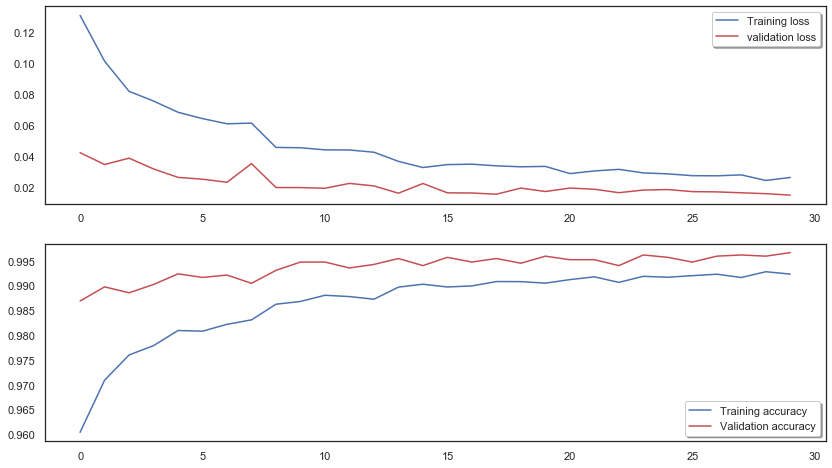

In [32]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1,figsize = (14,8))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

- ### Adams

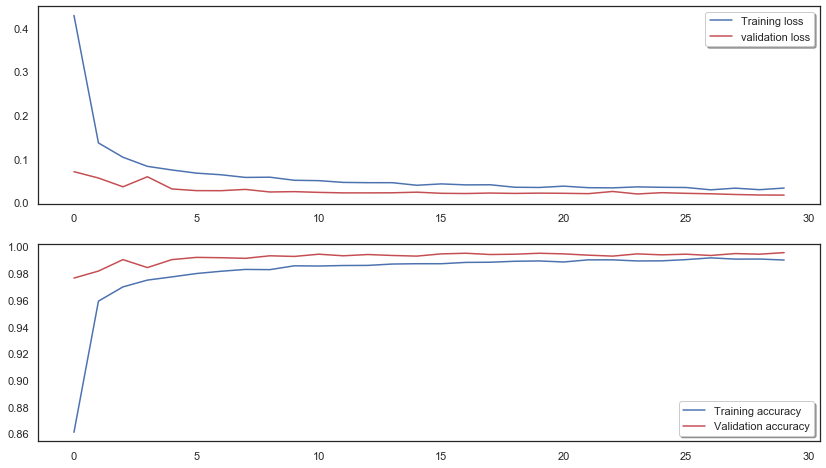

In [72]:
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2,1,figsize = (14,8))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## Confusion matrix

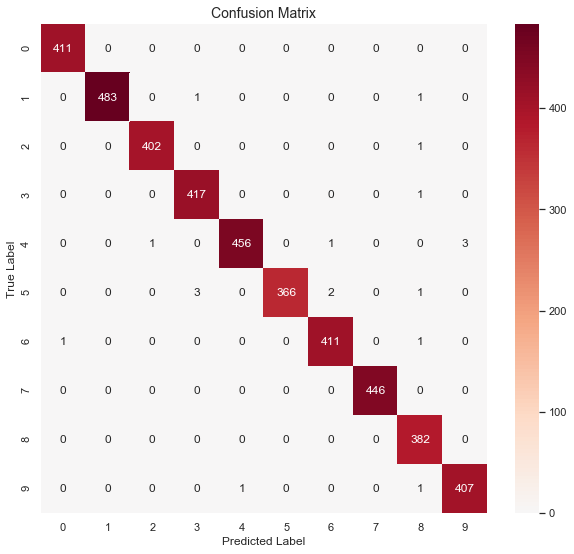

In [81]:
# confusion matrix
# Predict the values from the validation dataset
Y_pred = model.predict(valX)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(valY,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plt.figure(figsize=(10,9))
sns.heatmap(confusion_mtx, cmap='RdBu_r', annot=True, fmt= 'd', center=0.0)
plt.title("Confusion Matrix",fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Errors

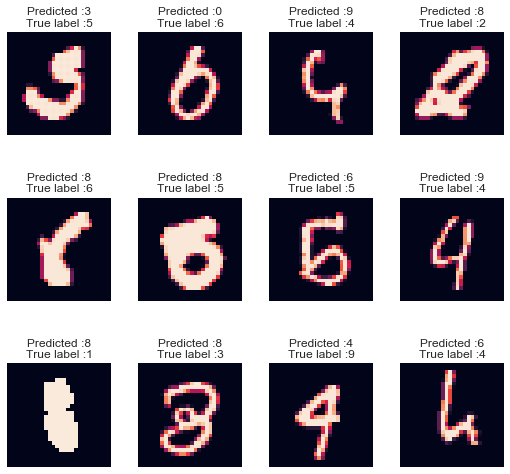

In [113]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
valX_errors = valX[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = int(np.sqrt(len(errors_index)))
    ncols = int(np.ceil(len(errors_index)/nrows))
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True, figsize = (nrows*3,ncols*2))
    plt.subplots_adjust(hspace = 0.6)
    for row in range(nrows):
        for col in range(ncols):
            if (row)*(ncols)+(col+1) > len(errors_index): return
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            ax[row,col].axis("off")
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top n errors 
most_important_errors = sorted_dela_errors[-12:]

# Show the top n errors
display_errors(most_important_errors, valX_errors, Y_pred_classes_errors, Y_true_errors)